In [37]:
import numpy as np

import sys
sys.path.append("..")
from nc_suite import *

In [38]:
# Create img and labels
from torchvision import datasets
import cv2

img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (28,28))

mnist = datasets.MNIST('data', train=True, download=True)
img = np.asarray(mnist[2][0])

label = np.copy(img) # shallow copy is fine, since it isn't python objects inside
label[label>0] = 1

In [39]:
# Really simple weighting methods...
# based on nc-test-multi these are the only consistent ones :)
# see TODO in nc-test-multi

# Image 1 (MNIST)
i_W = intensity_weight_matrix(img)
pi_W = intens_posit_wm(img)

# Image 2 (baby)
i_W_baby = intensity_weight_matrix(img_baby)
pi_W_baby = intens_posit_wm(img_baby)

In [40]:
from collections import OrderedDict

weights = OrderedDict(
    img=img, label=label, i_W=i_W, pi_W=pi_W,
    
    img_baby=img_baby, blank=np.zeros_like(img_baby), i_W_baby=i_W_baby, pi_W_baby=pi_W_baby
)

for key,value in weights.items(): #eigsh expects float or double
    weights[key] = value.astype(float)

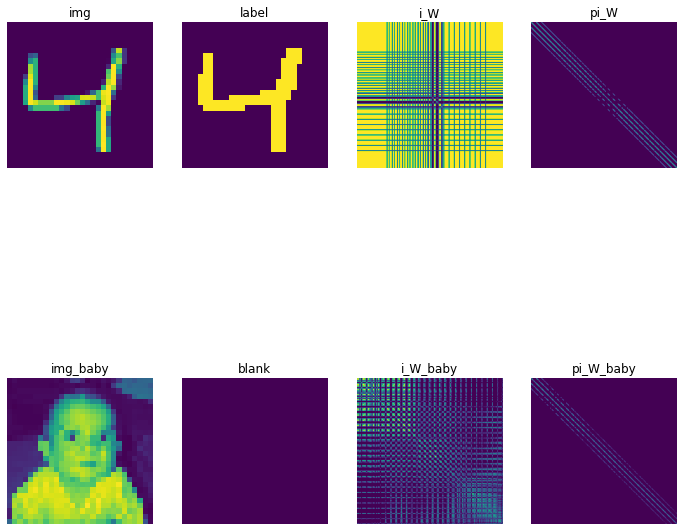

In [41]:
plt.rcParams["figure.figsize"] = (12,12) # specify the size for this cell
plot_images([weight for weight in weights.values()], 
            [key for key in weights.keys()],
            colmns=4)

In [42]:
# to store multiple different methods
from functools import partial

# the methods to store
import scipy.linalg as linalg
import scipy.sparse.linalg as sparse_linalg

def deterministic_vector_sign_flip(u):
    # from https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/extmath.py#L1097
    max_abs_rows = np.argmax(np.abs(u))
    signs = np.sign(u[max_abs_rows])
    u *= signs
    return u

def shift_invert(input, func):
    input = input * -1
    return func(input)

# np.random.seed(0)

# Ordered dict to iterate over
eigs_options = OrderedDict(
    eigh_cff = partial(linalg.eigh, check_finite=False),
)

def setdiag(m,d):
    step = len(d) + 1
    m.flat[::step] = d

# non symm laplacian
def non_symm(W):
    # Diagonal Matrix - D
    d = np.sum(W, axis=1)
    D = np.zeros_like(W)
    np.fill_diagonal(D, d)

    A = D - W
    return A

# symm laplacian 2
def symm2(W):
    L = W + W.T # ensure symmetric
    np.fill_diagonal(L,0)
    D = L.sum(0) # symmetric so axis doesn't matter
    isolated_mask = (D == 0)
    D = np.where(isolated_mask, 1, np.sqrt(D))
    L = L/D
    L = L/D[:, np.newaxis]
    L = L * -1
    setdiag(L, 1 - isolated_mask)
    return L

laplace_options = OrderedDict(
    # non_symm = non_symm,
    symm2 = symm2
)

In [43]:
from tqdm import tqdm
    
# solve with any given eigensolver and laplacian approach
def generic_solve(W, laplace,solver):
    L = laplace(np.copy(W))
    _, eig_vectors = solver(L)
    
    output = eig_vectors[:, 1]
    deterministic_vector_sign_flip(output)
    output = output.reshape(*np.sqrt(W.shape).astype(int)) 
    return output

def generic_solve_vals(W, laplace,solver):
    L = laplace(np.copy(W))
    vals, _ = solver(L)
    
    # output = eig_vectors[:, 1]
    # deterministic_vector_sign_flip(output)
    # output = output.reshape(*np.sqrt(W.shape).astype(int)) 
    return vals

outputs = []
errors = []

row_headers = []
col_headers = []
titles = []

for laplace_name, laplace_func in laplace_options.items(): # and each laplacian type
    if laplace_name not in titles:
        titles.append(laplace_name)
    
    sub_output = []
    for eig_name, eig_func in eigs_options.items(): # for each eigensolver    
        row_headers.append(eig_name)
        
        for weight_name, weight in (pbar := tqdm(weights.items())): # and each weight    
            pbar.set_description(f'{eig_name} - {laplace_name}')
            
            if weight_name not in ['img','img_baby', 'label', 'blank']: # that isn't some other array      
                if weight_name not in col_headers:
                    col_headers.append(weight_name)
                try:
                    out1 = generic_solve(weight, laplace_func, eig_func)
                    sub_output.append(out1) # solve and append its output
                except Exception as err:
                    sub_output.append(np.zeros_like(img))
                    errors.append(f'{eig_name} - {weight_name}\n{err=}\n')
    outputs.append(sub_output)

eigh_cff - symm2: 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


intensity, positonal * intensity


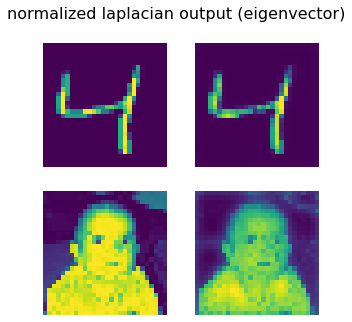

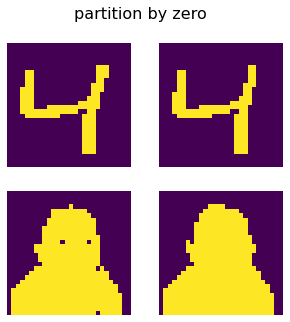

In [44]:
plt.rcParams["figure.figsize"] = (5,5) # specify the size for this cell

print('intensity, positonal * intensity')
for i in range(len(outputs)):
    plot_images(outputs[i],colmns=len(col_headers)//2, title='normalized laplacian output (eigenvector)') # row_headers=row_headers, col_headers=col_headers,
    plot_images([partition_by_zero(output) for output in outputs[i]], title='partition by zero')

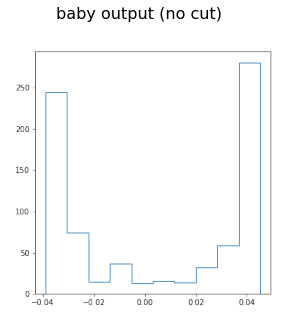

In [45]:
import io
plt.rcParams["figure.figsize"] = (5,5) # specify the size for this cell
# counts, bins = np.histogram(img_baby)
# plt.stairs(counts,bins)
# plt.title('baby input')
# plt.show()
# print(counts)
# print(bins)

def plot_bins_to_np(input, DPI=300):
    fig,ax = plt.subplots()
    counts, bins = np.histogram(input)
    ax.stairs(counts,bins)
    plt.tight_layout()
    
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    im = data.reshape((int(h), int(w), -1))
    plt.close()
    return im


plot_images([plot_bins_to_np(outputs[0][2])], title='baby output (no cut)')

In [46]:
import torch
import torch.nn as nn

def lech_loss(pred, mask):
    mask = mask.flatten(-2)[:,None,:]
    pred = pred.flatten(-2)[:,:,None]

    mask_bar = torch.div((mask+1),2) # y_n
    # pred_bar = torch.div((pred+1), 2) # yhat_n convert predicition to {0,1} roughly too
    # goes to 0 if not using above :)
    pred_bar = pred

    relu = nn.ReLU()

    loss = torch.bmm((1-mask_bar),(pred_bar+1)**2) + torch.bmm(mask_bar, relu(-pred_bar))
    return torch.mean(loss) # avg across batch I guess

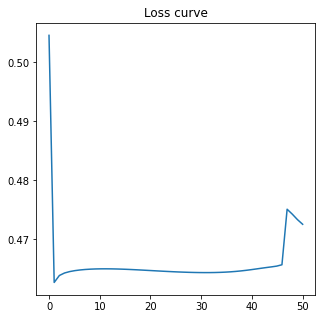

In [47]:
run = True # to stop excessive execution every time..


# Now, test a loss function as the outputs go
from scipy.interpolate import interp1d
from sklearn.datasets import make_spd_matrix

def relu(x):
    return np.maximum(0, x)

def make_good(x):
    x = np.tril(x) + np.tril(x, -1).T
    x = relu(x)
    return x

if run:
    W_true = intens_posit_wm(img_baby)
    W_true = make_good(W_true)

    W_rand = np.random.randn(*W_true.shape)
    W_rand = make_good(W_rand)

    def lerp(input, end, weight):
        return input + weight * (end - input)

    steps = 49

    weights = [W_true]
    preds = [generic_solve(W_true, symm2, partial(linalg.eigh, check_finite=False))]
    cuts = [partition_by_zero(preds[0])]
    histograms = [plot_bins_to_np(preds[0])]

    # loss func
    loss_func = nn.HingeEmbeddingLoss() # which takes params.. can can be used as loss_func(pred, target)
    pred_true = preds[0]
    pred_true = np.sign(preds[0])
    pred_true = torch.tensor(pred_true)

    losses = [loss_func(torch.tensor(preds[0]), pred_true).item()]

    for i in range(1,steps+1):
        weight = lerp(weights[-1], W_rand, 0.1)
        weight = make_good(weight)
        pred = generic_solve(weight, symm2, partial(linalg.eigh, check_finite=False)) # * 28
        cut = partition_by_zero(pred)
        histogram = plot_bins_to_np(pred, 500)
        
        histograms.append(histogram)
        weights.append(weight)
        preds.append(pred)
        cuts.append(cut)
        
        loss = loss_func(torch.tensor(pred), pred_true).item()
        losses.append(loss)
        
        # print()
        
    # for loss in losses:
    #     print(loss)
    plt.rcParams["figure.figsize"] = (5,5)
    plt.figure()
    x = np.linspace(0, steps+1, steps+1)
    plt.plot(x, losses)
    plt.title('Loss curve')
    plt.show()

# TODO: understand how minor permutations will effect the output...
# TODO: test for different datasets (e.g. the ones I generate myself as well)
# TODO: run the model (train for weights only, train for cut)

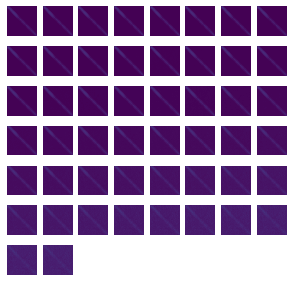

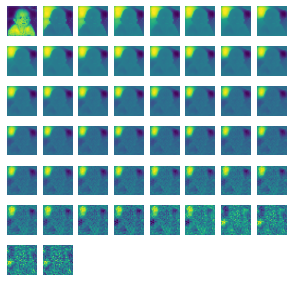

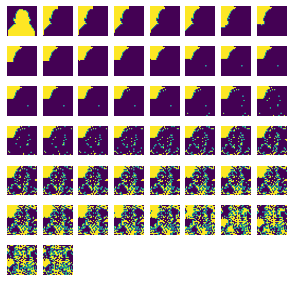

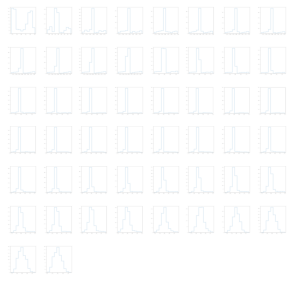

In [48]:
plt.rcParams["figure.figsize"] = (5,5) # specify the size for this cell
plot_images(weights)
plot_images(preds)
plot_images(cuts)
plot_images(histograms)

In [49]:
imgs = [np.asarray(mnist[x][0]) for x in range(30)]

cuts = []
preds_bar = []
preds = []
eigvals = []
for img in imgs:
    weight = intens_posit_wm(img)
    pred = generic_solve(weight, symm2, partial(linalg.eigh, check_finite=False))
    
    preds_bar.append(pred.flatten())
    preds.append(pred)
    cuts.append(partition_by_zero(pred))
    
    eigval_list = generic_solve_vals(weight, symm2, partial(linalg.eigh, check_finite=False))
    eigvals.append(eigval_list)
    

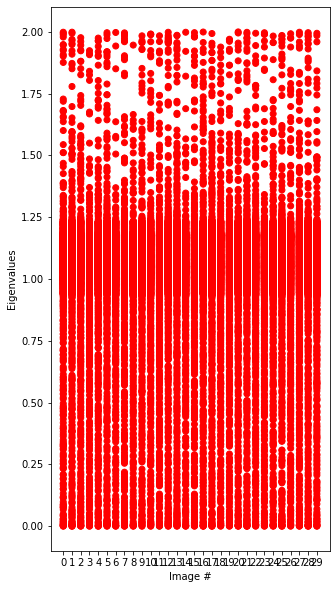

In [50]:
# Plot the range of eigenvalues for a given image

plt.rcParams["figure.figsize"] = (5,10)
fig, ax = plt.subplots()

# Symmetric laplacian to get only positive eigenvalues... both output cuts but one is correct math

# iterate over each array in the list and create a scatter plot
for i, val in enumerate(eigvals):
    x = [i] * len(val)
    colors = ['r' if v > 0 else 'g' for v in val]
    ax.scatter(x, val, c=colors)
    # ax.set_ylim(0,0.0005)

# set axis labels and show the plot
plt.xticks(range(len(eigvals)), range(len(eigvals)))
plt.xlabel('Image #')
plt.ylabel('Eigenvalues')
plt.show()

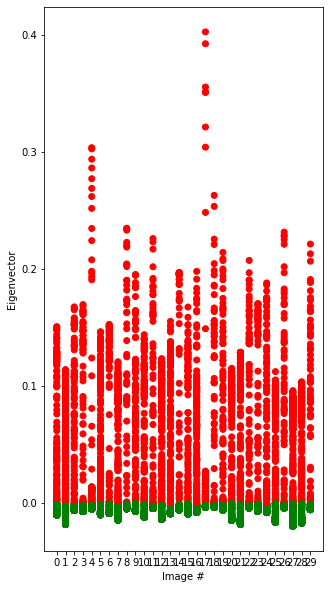

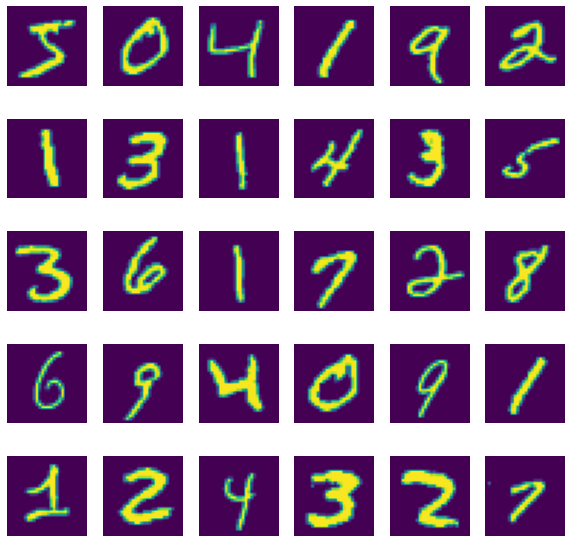

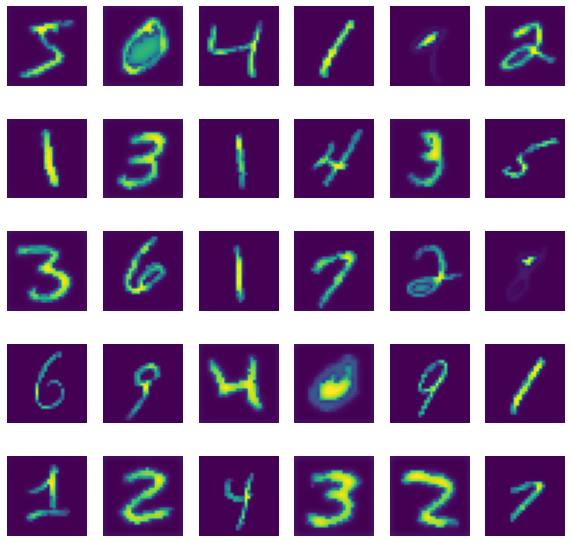

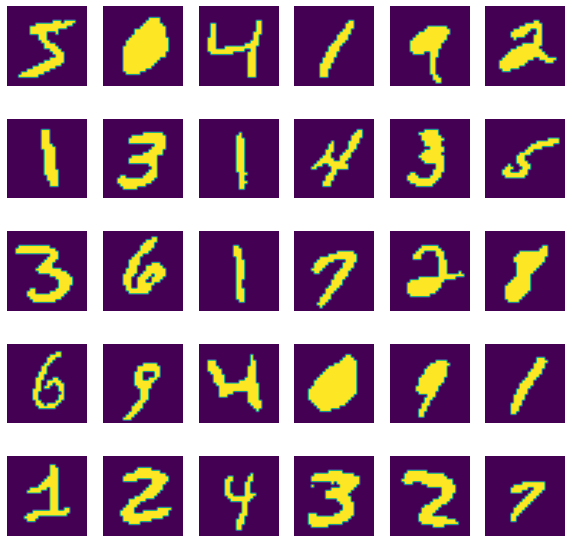

In [51]:
# range of values in eigenvector
# and the plots of input, output, cut

plt.rcParams["figure.figsize"] = (5,10) # specify the size for this cell

fig, ax = plt.subplots()

# iterate over each array in the list and create a scatter plot
for i, val in enumerate(preds_bar):
    x = [i] * len(val)
    colors = ['r' if v > 0 else 'g' for v in val]
    ax.scatter(x, val, c=colors)

# set axis labels and show the plot
plt.xticks(range(len(preds_bar)), range(len(preds_bar)))
plt.xlabel('Image #')
plt.ylabel('Eigenvector')
plt.show()

plt.rcParams["figure.figsize"] = (10,10)

plot_images(imgs)
plot_images(preds)
plot_images(cuts)